In [5]:
#########################################################################
# LIBRERIAS NECESARIAS
#########################################################################
import gymnasium as gym
import numpy as np
import sinergym
from sinergym.utils.wrappers import LoggerWrapper
import torch

import tensorflow as tf
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
from sklearn.model_selection import train_test_split
import csv

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2023-11-07 17:31:53.728088: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 17:31:53.757747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 17:31:54.320896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
############################################################################
# Variables globales
###########################################################################
BATCH_SIZE = 28032
EPOCHS =100
EPISODES = 1
EPISODES_EVALUATE_G=5
TOTAL_TIMESTEPS_PPO_GENERATOR=250

In [7]:
# Definimos el entorno Warehouse
env = gym.make('Eplus-warehouse-hot-discrete-v1')
env = LoggerWrapper(env)

# Obtenemos el espacio de observaciones y el espacio de acciones del entorno env
ob_space = env.observation_space
ac_space = env.action_space

# Mostramos el número de observaciones y de acciones del entorno 5Zone
print('\n Nº de observaciones: ', ob_space.shape[0])
print('\n Nº de acciones: ', ac_space.n)

[2023-11-07 17:31:55,450] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-11-07 17:31:55,451] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-11-07 17:31:55,452] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating building model OutPut:Variable and variables XML tree model for BVCTB connection.
[2023-11-07 17:31:55,453] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Setting up extra configuration in building model if exists...
[2023-11-07 17:31:55,453] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Setting up action definition in building model if exists...

 Nº de observaciones:  23

 Nº de acciones:  10


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.variables to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.variables` for environment variables or `env.get_wrapper_attr('variables')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.simulator to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.simulator` for environment variables or `env.get_wrapper_attr('simulator')` that will search the reminding wrappers.
  logger.warn(


# Disriminador

## Red neuronal del Discriminador

In [8]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o falsas, de longitud 2*ob_space.shape[0] + ac_space.n+1. 
# Output: probabilidad de real o falso perteneciente al intervalo [0,1]
discriminator_net = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n)),
        layers.Dense(units=15, activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=15, activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=15, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 15)          510       
                                                                 
 layer2 (Dense)              (None, None, 15)          240       
                                                                 
 layer3 (Dense)              (None, None, 15)          240       
                                                                 
 prob (Dense)                (None, None, 1)           16        
                                                                 
Total params: 1006 (3.93 KB)
Trainable params: 1006 (3.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Discriminador 

In [9]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a] de la base de datos 
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a] 
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))
    
    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))
    
    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)
    
    loss = loss_expert + loss_agent
    
    loss = -loss

    return loss

## Clase del Discriminador

In [10]:
class Discriminator:
    def __init__(self,env,discriminator_net,expert_s,expert_a,agent_s,agent_a):

        # -Red neuronal del Discriminador
        self.discriminator_net = discriminator_net

        # 1) Secuencia experta: [s,a]
        self.expert_s = expert_s
        self.expert_a = expert_a
        expert_a_one_hot = tf.one_hot(self.expert_a, depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot += tf.random.normal(tf.shape(expert_a_one_hot),mean=0.2,stddev=0.1,dtype=tf.float32) / 1.2
        # expert_s_a=>secuencia experta=>[s,a]
        self.expert_s_a = tf.concat([self.expert_s, expert_a_one_hot], axis=1)

        # 2) Secuencia agente:  [s,a]
        self.agent_s = agent_s
        self.agent_a = agent_a
        agent_a_one_hot = tf.one_hot(self.agent_a, depth=env.action_space.n)
        agent_a_one_hot += tf.random.normal(tf.shape(agent_a_one_hot),mean=0.2,stddev=0.1,dtype=tf.float32) / 1.2
        # agent_s_a=>secuencia agente=>[s,a]
        self.agent_s_a = tf.concat([self.agent_s, agent_a_one_hot], axis=1)

        # Calculamos la salida de la red para [s,a] del experto y [s,a] del agente 

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert = self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent = self.discriminator_net(self.agent_s_a)

        # -Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards = tf.math.log(tf.clip_by_value(self.prob_agent, 1e-10, 1))

    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards

# Generador

## Redes neuronales del Generador

In [11]:
# Red neuronal del Generador donde se producen acciones
# Input: estados, listas de tamaño 20, s=[s1,s2,s3,....,s23]
# Output: acciones, listas de tamaño 10, a=[a1,a2,....,a10]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=20, activation=tf.tanh, name='layer1'),
        layers.Dense(units=20, activation=tf.tanh, name='layer2'),
        layers.Dense(units=15, activation=tf.tanh, name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          480       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 15)          315       
                                                                 
 layer4 (Dense)              (None, None, 10)          160       
                                                                 
Total params: 1375 (5.37 KB)
Trainable params: 1375 (5.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Red neuronal del Generador donde se producen v_pred
# Input: estados, listas de tamaño 20, s=[s1,s2,s3,....,s17]
# Output: v_pred, listas de tamaño 1, v_pred(s)

generator_net_v_preds = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=20, activation=tf.tanh, name='layer1'),
        layers.Dense(units=20, activation=tf.tanh, name='layer2'),
        layers.Dense(units=1, activation=None, name='layer3'),
    ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          480       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 1)           21        
                                                                 
Total params: 921 (3.60 KB)
Trainable params: 921 (3.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador 

In [13]:
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated" 
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)
    
    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador 

In [14]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator

class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env = env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal  
        self.model = PPO(policy="MlpPolicy", env=env, verbose=0)

        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)  # 25000)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs = np.reshape(np.array(obs), (1, ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs = generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical( tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)

    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística

    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a] falsos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0
        success_num = 0

        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            run_policy_steps = 0

            truncated = False
            terminated = False

            # La primera acción de cada episodio se crea con la red neuronal

            obs,_ = env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=[obs])

            act, _ = Old_Policy.act(stochastic=True)

            # Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act = act.numpy()

            elif isinstance(act, np.ndarray):
                act = act

            action = int(act)

            next_obs, reward, terminated, truncated, _ = env.step(action)

            # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
            observations.append(next_obs)  # S_0

            # tenemos una política entrenada
            Policy = Policy_net('policy', env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un
            # estado terminal o un estado malo
            while terminated != True and truncated != True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_0,s_1,s_2,....]] por eso su tamaño es (1,n)
                action, _ = Policy.get_model().predict(next_obs)

                action = int(action)

                # --Muevo al Agente al siguiente estado
                next_obs, reward, terminated, truncated, _ = env.step(action)

                # --Actualización de variables
                actions.append(action)  # A_i-1
                rewards.append(reward)  # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated or truncated:
                    obs,_= env.reset()
                    reward = -1
                    break
                else:
                    observations.append(next_obs)  # S_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                if success_num >= 100:
                    break
            else:
                success_num = 0

        observations = np.reshape(observations,newshape=[-1] + list(ob_space.shape))

        actions = np.array(actions).astype(dtype=np.int32)

        return observations, actions, rewards, Old_Policy, Policy



In [15]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN
class PPOTrain:
    def __init__(self,Policy,Old_Policy,obs,actions,rewards,gamma=0.95):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs = obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()

        policy_dict_ = self.pi_trainable["policy"]
        old_policy_dict_ = self.old_pi_trainable["policy"]

        self.pi = []
        if "policy" in self.pi_trainable and  "policy" in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print("No se encontró la política con el nombre: policy")

        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos
        # nuevos pi_trainable
        self.actions = actions
        self.rewards = rewards
        self.v_preds = self.Old_Policy.get_v_preds()
        self.v_preds_next = self.Policy.get_v_preds()
        
        #  La estimación de la función ventaja GAES, ver paper PPO
        self.gaes = self.get_gaes(self.rewards,self.v_preds,self.v_preds_next)

        act_probs = self.Policy.get_action_prob()
        act_probs_old = self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss = loss_fn_ppo( self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma *v_next - v for r_t, v_next, v in zip(rewards,v_preds_next,v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) -1)):  # es T-1, donde T es time step con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes


# GAIL 

In [16]:
##########################################################################
# CLASE GAIL
##########################################################################

class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self, d_optimizer, loss_fn_D):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D = loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
    
        len_real = X_test.shape[0]

        # Generamos datos falsos dataset_gen = [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy = self.generator.generate_fakes()

        generate_a_one_hot = np.eye(env.action_space.n)[generate_actions]

        dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)


        dataset_gen = dataset_gen.astype('float32')
        dataset_gen[-ac_space.n:] = dataset_gen[-ac_space.n:].astype('int32')
        dataset_gen= tf.convert_to_tensor(dataset_gen)
        
        X_test = X_test.astype('float32')
        X_test[-ac_space.n:] = X_test[-ac_space.n:].astype('int32')

    
        len_fakes = dataset_gen.shape[0]


        # Compilamos el discriminador como CNN
        discriminator_net.compile( optimizer=tf.keras.optimizers.Adam( learning_rate=1e-5), loss=loss_fn_D, metrics=['accuracy'])

        #Evaluamos como CNN
        loss_real, acc_real = discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake =discriminator_net.evaluate(dataset_gen, tf.ones((len_fakes, 1)), batch_size=len_fakes, verbose=1)

        print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
        print('>Loss real: ')
        
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)

    
    # Evaluación del generador

    def evaluate_G(self):
        # Definimos el entorno
        env = gym.make('Eplus-warehouse-hot-discrete-v1')
        env = LoggerWrapper(env)

        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen
        # la recompensa

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        rewards = []

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la
        # GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated = False
            terminated = False
            R = 0.0
            reward = 0.0

            # Estado inicial del juego
            obs, _ = env.reset()

            # Interactuamos con el Entorno hasta que lleguemos a un estado
            # final
            while terminated != True and truncated != True:
                action, _ = self.generator.get_model().predict(obs)
                obs, reward, terminated, truncated, _ = env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R += reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se
            # trata de maximizar
            print("Episode  {} Total reward: {}".format(episode, R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices, rewards)
        plt.show()

        return np.mean(rewards)
    
    def train_step(self, X_train):
        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy = self.generator.generate_fakes()

        generate_a_one_hot = np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
            dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
            generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
            dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

    
        dataset_gen = dataset_gen.astype('float32')
        dataset_gen[-10:] = dataset_gen[-10:].astype(int)

        dataset_gen= tf.convert_to_tensor(dataset_gen)

        # 2) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento
        X_train = tf.strings.to_number(X_train)
        X_train = tf.cast(X_train, dtype=tf.float32)

        combined_images = tf.concat([X_train, dataset_gen], axis=0)
        
        # 3) Longitud de datos pueden ser diferente en secuencias reales y secuencias falsas. 
        # Tener en cuenta que no tenemos la misma cantidad de datos verdaderos y falsos, por eso calculamos len_real y len_fakes
        # No podemos controlar la creación de x secuencias [s,a, s', r] ya que generaremos tantas secuencias como se necesiten para finalizar el juego
        len_fakes = dataset_gen.shape[0]
        len_real = X_train.shape[0] 

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((len_real, 1)), tf.zeros((len_fakes, 1))],axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR 
        #############################################################################################################################################################

        # Entrenamiento del discriminador con las [s,a] del agente (falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto trayectorias reales como trayectorias falsas
        with tf.GradientTape() as tape:
            predictions = np.zeros((len_real + len_fakes, ob_space.shape[0] + ac_space.n))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.getNet().trainable_weights)
        )

        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA 
        ######################################################################################################################

        ppotrain = PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards,obs=generate_observations[0])

        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()

        g_loss = tf.cast(g_loss, dtype=tf.float32)

        #################################################################################################################################################################
        # PASO 3: Cada 10 épocas, ejecutamos al generador (agente) sobre el entorno. Esto es, llamamos al método evaluate_G.  
        #################################################################################################################################################################
        # Por cada 10 epoca quiero conocer los datos de recompensa
        if (self.i+1)%10==0:
          rewardMean=self.evaluate_G()
          print('\nEpoca:', self.i+1)
          print('\nRecompensa de Media:', rewardMean, '\n')

        self.i=self.i+1

        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}



# Base de datos experta

In [17]:
##########################################################################
# LECTURA DEL DATASET REAL
##########################################################################
with open('observations_Warehouse.csv', 'r') as archivo_csv:
    # Crear el lector CSV
    expert_observations = csv.reader(archivo_csv)
    with open('actions_Warehouse.csv', 'r') as archivo_csv:
        expert_actions = csv.reader(archivo_csv)

        # Construimos el dataset [s,a] reales y lo dividimos en training y test
        expert_actions = [int(item[0]) for item in list(expert_actions)][:]
        expert_a_one_hot = np.eye(env.action_space.n)[expert_actions]
        expert_observations = list(expert_observations)
        expert_observations = np.array(expert_observations)
        dataset = np.concatenate([expert_observations, expert_a_one_hot], axis=1)

        print('\n Tamanio del dataset: ', dataset.shape)
        print('\n Primera fila del dataset: ', dataset[0])




 Tamanio del dataset:  (35040, 33)

 Primera fila del dataset:  ['1991.0' '1.0' '1.0' '0.0' '4.0' '69.0' '3.1' '130.0' '0.0' '0.0' '21.0'
 '25.0' '20.362167' '21.405642' '0.0' '21.0' '25.0' '20.997826'
 '21.426332' '21.0' '21.000208' '20.894255' '1232.3416' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0']


In [18]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


# Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 28032
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 7008


# EXPERIMENTACIÓN DE GAIL CON WAREHOUSE

## Definición de generador y discriminador 

In [19]:
obs, info = env.reset(seed=1)

# Generador
generator = Policy_net('policy', env, obs)

# Generamos [s,a]=[observations,actions] falsas y las políticas theta_i=Old_Policy y theta_i+1=Policy
observations, actions, rewards, Old_Policy, Policy = generator.generate_fakes()

# Discriminador
discriminator = Discriminator(env,discriminator_net,expert_observations,expert_actions,observations,actions)


[2023-11-07 17:31:56,139] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:31:56,221] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run1


/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: Runt

[2023-11-07 17:32:06,808] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:32:06,812] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:32:07,313] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run2
[2023-11-07 17:32:20,056] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:32:20,058] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:32:20,153] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run3
[2023-11-07 17:33:07,438] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Ene

## Experimento 1: 


### Definición de Extended GAIL 

In [20]:
gan = GAN(discriminator=discriminator, generator=generator)

### Compilación de  GAIL

In [21]:
tf.config.run_functions_eagerly(True)

# Compilación 
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss_fn_D=loss_fn_D
)


### Entrenamiento de GAIL

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[2023-11-07 17:35:01,029] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:35:01,030] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:35:01,136] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run10
[2023-11-07 17:35:14,199] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:35:14,201] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:35:14,294] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run11
[2023-11-07 17:35:26,775] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:E

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46082.24531713697
[2023-11-07 17:54:23,527] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:54:23,527] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:54:23,528] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:54:23,528] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:54:23,644] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res157/Eplus-env-sub_run2
[2023-11-07 17:54:23,644] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res157/Eplus-env-sub_run2
Episode  1 Total reward: -46113.8963219074

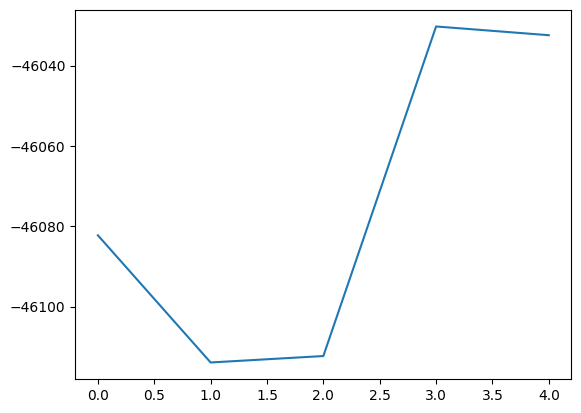


Epoca: 10

Recompensa de Media: -46074.23115637561 

1/1 [==============================] - 334s 334s/step - d_loss: 4.9831 - g_loss: 1.3685
Epoch 11/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 17:57:37,667] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:57:37,667] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 17:57:37,669] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:57:37,669] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 17:57:37,779] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run70
[2023-11-07 17:57:37,779] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run70
[2023-11-07 17:57:51,811] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:E

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46121.35712203518
[2023-11-07 18:18:01,798] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:18:01,798] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:18:01,798] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:18:01,800] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:18:01,800] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:18:01,800] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:18:01,911] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res158/Eplus-

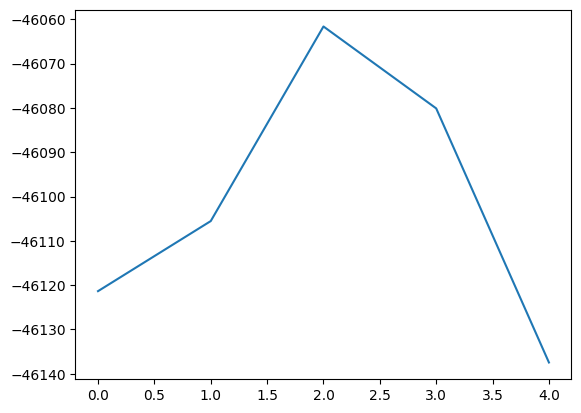


Epoca: 20

Recompensa de Media: -46101.214706868814 

1/1 [==============================] - 352s 352s/step - d_loss: 4.9541 - g_loss: 1.2193
Epoch 21/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 18:21:06,619] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:21:06,619] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:21:06,619] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:21:06,621] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:21:06,621] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:21:06,621] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:21:06,736] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res156/Eplus-env-sub_run130
[2023-11-07 18:21:06,736] EPL

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46014.246269548654
[2023-11-07 18:35:13,391] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:35:13,391] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:35:13,391] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:35:13,391] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:35:13,393] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:35:13,393] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:35:13,393] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:35:13,393] EPLUS_ENV_warehouse-hot-discrete-v

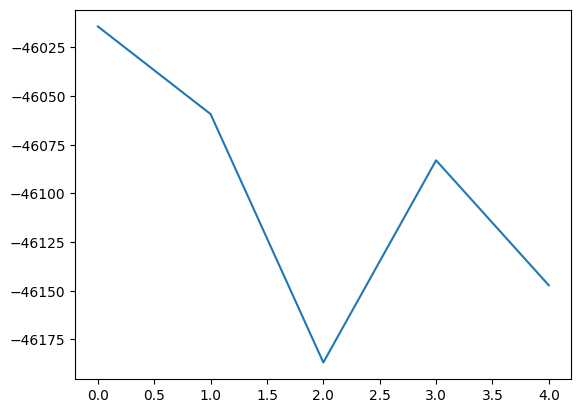


Epoca: 30

Recompensa de Media: -46098.1319452129 

1/1 [==============================] - 213s 213s/step - d_loss: 4.9446 - g_loss: 1.2352
Epoch 31/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 18:37:08,144] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:37:08,144] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:37:08,144] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:37:08,144] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:37:08,145] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:37:08,145] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:37:08,145] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:37:08,145] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlu

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46144.899116766814
[2023-11-07 18:51:11,195] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:51:11,195] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:51:11,195] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:51:11,195] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:51:11,195] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:51:11,198] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:51:11,198] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:51:11,198] EPLUS_ENV_warehouse-hot-discrete-v1_

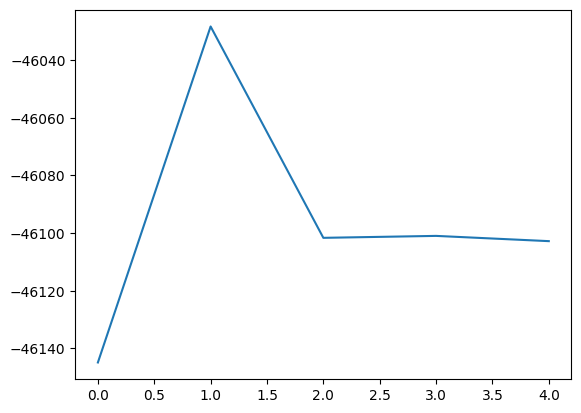


Epoca: 40

Recompensa de Media: -46095.74350345184 

1/1 [==============================] - 212s 212s/step - d_loss: 4.8984 - g_loss: 1.2283
Epoch 41/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 18:53:03,561] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:53:03,561] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:53:03,561] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:53:03,561] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:53:03,561] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 18:53:03,563] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:53:03,563] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 18:53:03,563] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus 

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46141.4538465008
[2023-11-07 19:07:13,545] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:07:13,545] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:07:13,545] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:07:13,545] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:07:13,545] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:07:13,545] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:07:13,548] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 19:07:13,548] EPLUS_ENV_warehouse-hot-discrete-v1_Main

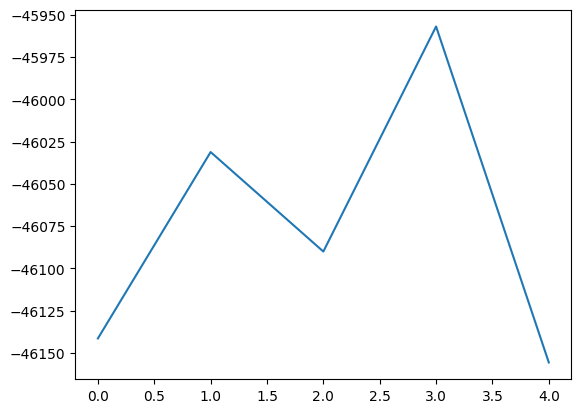


Epoca: 50

Recompensa de Media: -46075.06083296942 

1/1 [==============================] - 214s 214s/step - d_loss: 4.8829 - g_loss: 1.2338
Epoch 51/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 19:09:07,369] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:09:07,369] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:09:07,369] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:09:07,369] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:09:07,369] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:09:07,369] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:09:07,371] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 19:09:07,371] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus si

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46037.68872844945
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,920] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:23:12,921] EPLUS_ENV_warehouse-hot-discrete-v1_MainT

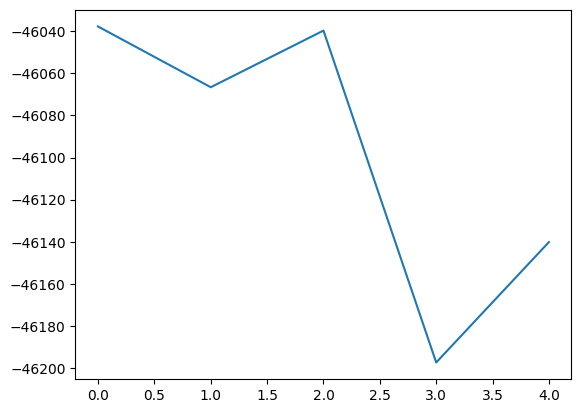


Epoca: 60

Recompensa de Media: -46096.29506456759 

1/1 [==============================] - 211s 211s/step - d_loss: 4.8306 - g_loss: 1.2278
Epoch 61/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,972] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:25:04,978] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simu

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46081.79184429727
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:38:42,732] EPLUS_ENV_warehouse-hot-discrete-v1_MainT

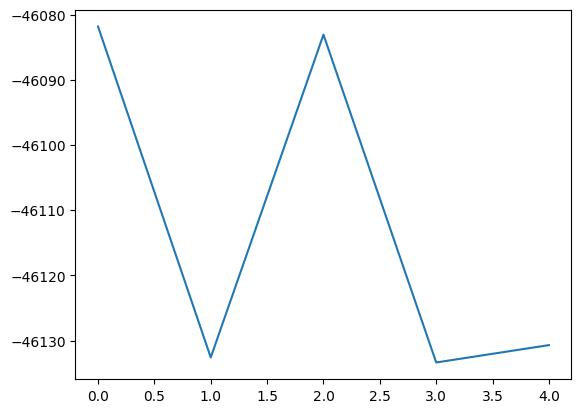


Epoca: 70

Recompensa de Media: -46112.29984200049 

1/1 [==============================] - 207s 207s/step - d_loss: 4.7941 - g_loss: 1.4697
Epoch 71/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:40:32,856] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46077.3087105842
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:54:41,551] EPLUS_ENV_warehouse-hot-discrete-v1_MainTh

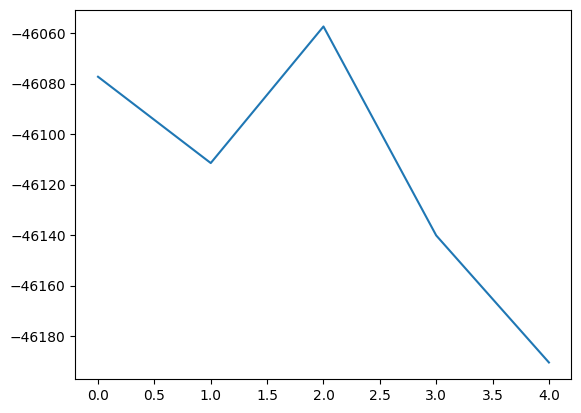


Epoca: 80

Recompensa de Media: -46115.36851865912 

1/1 [==============================] - 221s 221s/step - d_loss: 4.7605 - g_loss: 1.2428
Epoch 81/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 19:56:40,040] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46103.00547895266
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:11:15,243] EPLUS_ENV_warehouse-hot-discrete-v1_MainT

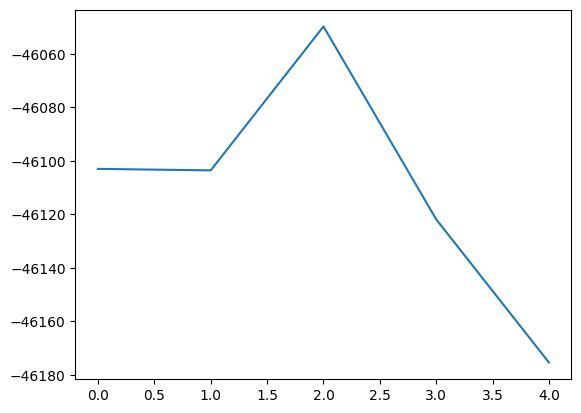


Epoca: 90

Recompensa de Media: -46110.712351225324 

1/1 [==============================] - 224s 224s/step - d_loss: 4.7093 - g_loss: 1.2117
Epoch 91/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:13:15,368] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -46048.64370151849
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:30:55,383] EPLUS_ENV_warehouse-hot-discrete-v1_MainT

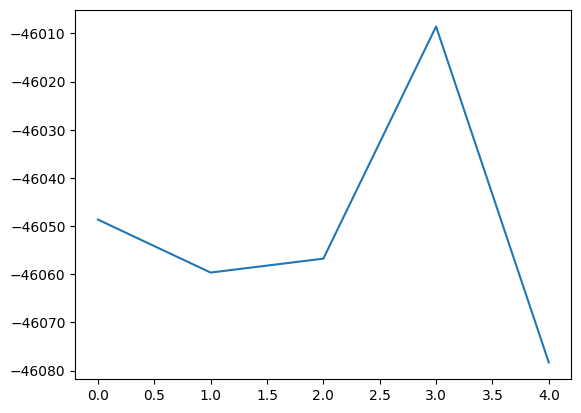


Epoca: 100

Recompensa de Media: -46050.38396201834 

1/1 [==============================] - 324s 324s/step - d_loss: 4.6575 - g_loss: 1.2257


In [22]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Entrenamiento GAIL
history = gan.fit(X_train,epochs=EPOCHS, batch_size=BATCH_SIZE)

### Evaluación de GAIL

In [23]:
gan.evaluate_D(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 20:33:57,059] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# Análisis de Experimentos 

In [24]:
# Librerias necesarias para la visualización
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Experimento 1

In [28]:
x=[10,20,30,40,50,60,70,80,90,100]
y=[-46074.23,-46101.21,-46098.13,-46095.74,-46075.06,-46096.29,-46112.29,-46115.36,-46110.71,-46050.38]

df = pd.DataFrame({'x': x, 'y': y})

### Gráfica de Recompensa Media/ Épocas

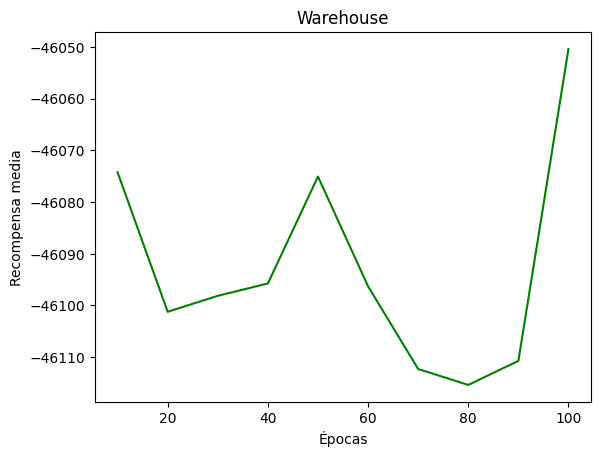

In [29]:
plt.plot(x, y, label='Warehouse',color='green')

#Agregamos las etiquetas y añadimos una leyenda.
plt.xlabel('Épocas')
plt.ylabel('Recompensa media')
plt.title("Warehouse")
# plt.legend()
plt.savefig('grafica_Warehouse_Extended_Gail.png')
plt.show()

### Estimación estadística: Modelo de Regresión Lineal 

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


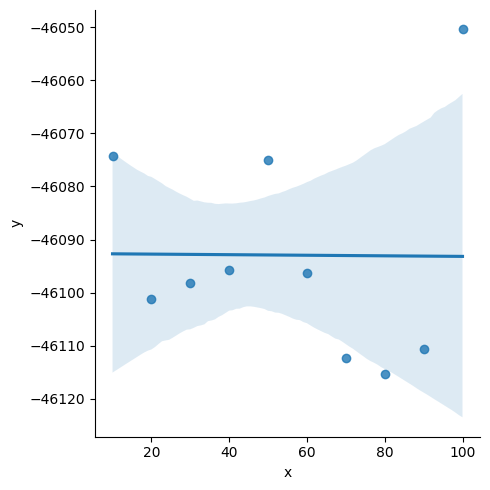

In [30]:
sns.lmplot(data=df, x="x", y="y")